Estado estacionario:
k: 28.3484
c: 1.7036
y: 3.0153
g: 0.6031
b: 0.9046
r: 0.0101

Simulando modelo...


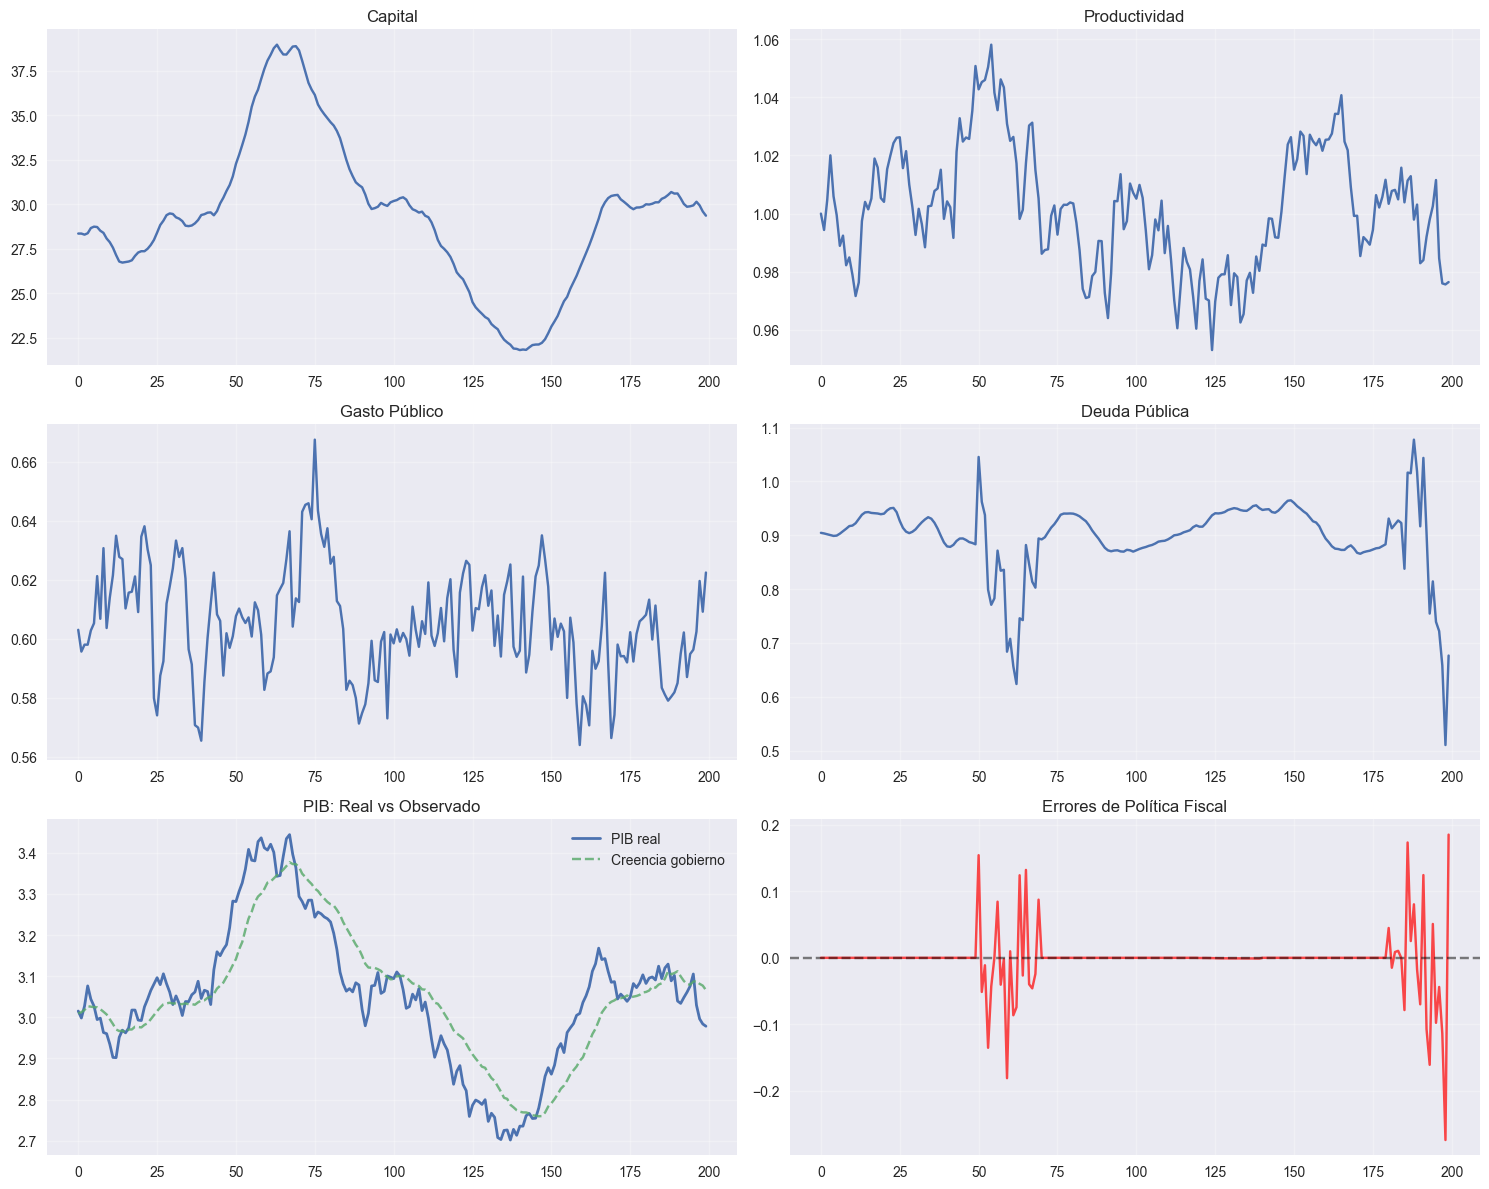


Estadísticas:
Error promedio: 0.0152
PIB promedio: 3.0503
Valores negativos de PIB: 0
RMSE entre PIB real y creencia: 0.0784


In [12]:
# DSGE Model with Imperfect Information and Government Learning

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from dataclasses import dataclass
import sympy as sp
import seaborn as sns

plt.style.use('seaborn-v0_8')

# --- 1. PARAMETERS --- #

@dataclass
class DSGEParameters:
    beta: float = 0.99
    gamma: float = 2.0
    alpha: float = 0.33
    delta: float = 0.025
    rho_a: float = 0.9
    sigma_a: float = 0.01
    rho_g: float = 0.8
    sigma_g: float = 0.02
    tau: float = 0.2
    phi_debt: float = 0.1
    sigma_signal: float = 0.01
    learning_speed: float = 0.1


# --- 2. DSGE MODEL CLASS --- #

class DSGEModel:
    def __init__(self, params: DSGEParameters):
        self.params = params
        self.steady_state = self.compute_steady_state()
        self.government_belief = 0.0

    def compute_steady_state(self):
        p = self.params
        r_ss = 1/p.beta - 1
        k_ss = (p.alpha / (r_ss + p.delta))**(1/(1-p.alpha))
        y_ss = k_ss**p.alpha
        g_ss = 0.2 * y_ss
        c_ss = (1 - p.tau) * y_ss - p.delta * k_ss
        deficit_ss = g_ss - p.tau * y_ss
        b_ss = deficit_ss / r_ss if deficit_ss > 0 else 0.3 * y_ss
        return {'k': k_ss, 'c': c_ss, 'y': y_ss, 'g': g_ss, 'b': b_ss, 'r': r_ss}

    def numerical_linearization(self):
        p = self.params
        ss = self.steady_state
        rho_k = 1 - p.delta
        debt_gdp_ratio = max(ss['b'] / ss['y'], 0.01)
        fiscal_multiplier = p.tau / debt_gdp_ratio
        A = np.array([
            [rho_k, p.alpha/(1-p.alpha), -0.05, -0.01],
            [0.0, p.rho_a, 0.0, 0.0],
            [0.0, 0.0, p.rho_g, 0.0],
            [-p.alpha * fiscal_multiplier * 0.1, -fiscal_multiplier * 0.1, 0.2, 0.95]
        ])
        B = np.array([
            [0.0, 0.0],
            [p.sigma_a, 0.0],
            [0.0, p.sigma_g],
            [0.0, 0.1 * p.sigma_g]
        ])
        return A, B

    def government_signal_extraction(self, true_state, t, bias=0):
        p = self.params
        ss = self.steady_state
        k_hat, a_hat = true_state[0], true_state[1]
        k_level = ss['k'] * np.exp(k_hat)
        a_level = np.exp(a_hat)
        true_y = a_level * (k_level ** p.alpha)
        uncertainty_factor = {
            'normal': 1.0,
            'elevated': 1.3,
            'high': 1.7,
            'extreme': 2.2
        }.get(self.current_uncertainty, 1.0)

        noise_std = p.sigma_signal * uncertainty_factor * max(true_y, ss['y'] * 0.1)

        noise = np.random.normal(0, noise_std)
        noisy_signal = max(true_y + noise + bias * ss['y'], 0.01 * ss['y'])
        if not hasattr(self, "government_belief") or np.isnan(self.government_belief):
            self.government_belief = ss['y']
        self.government_belief = (
            (1 - p.learning_speed) * self.government_belief + p.learning_speed * noisy_signal
        )
        return noisy_signal, self.government_belief

    def government_policy_rule(self, observed_y, debt_level, uncertainty_regime):
        p = self.params
        ss = self.steady_state
        debt_level_actual = ss['b'] * np.exp(debt_level)
        uncertainty_multiplier = {
            'normal': 1.0,
            'elevated': 1.2,
            'high': 1.5,
            'extreme': 2.0
        }
        base_response = -p.phi_debt * (debt_level_actual - ss['b'])
        uncertainty_adjustment = uncertainty_multiplier[uncertainty_regime]
        if uncertainty_regime in ['high', 'extreme']:
            implementation_error = np.random.normal(0, 0.05 * uncertainty_adjustment)
        else:
            implementation_error = 0
        return base_response * uncertainty_adjustment + implementation_error

    def simulate_model(self, T=200, uncertainty_episodes=None, bias=0.0):
        A, B = self.numerical_linearization()
        p = self.params
        ss = self.steady_state
        X = np.zeros((4, T))
        signals, beliefs = np.zeros(T), np.zeros(T)
        policy_errors = np.zeros(T)
        uncertainty_regimes = ['normal'] * T
        if uncertainty_episodes:
            for start, end, regime in uncertainty_episodes:
                uncertainty_regimes[start:end] = [regime] * (end - start)
        self.government_belief = ss['y']
        self.current_uncertainty = uncertainty_regimes[0]
        signal0, belief0 = self.government_signal_extraction(X[:, 0], 0)
        signals[0], beliefs[0] = signal0, belief0
        for t in range(1, T):
            epsilon = np.random.multivariate_normal([0, 0], np.eye(2))
            X[:, t] = A @ X[:, t-1] + B @ epsilon
            self.current_uncertainty = uncertainty_regimes[t]
            signal, belief = self.government_signal_extraction(X[:, t], t, bias=bias)
            signals[t], beliefs[t] = signal, belief
            debt_hat = X[3, t-1]
            fiscal_policy = self.government_policy_rule(belief, debt_hat, uncertainty_regimes[t])
            debt_level = ss['b'] * np.exp(debt_hat)
            optimal_policy = -p.phi_debt * (debt_level - ss['b'])
            policy_errors[t] = fiscal_policy - optimal_policy
            X[3, t] += fiscal_policy / ss['b']
        X_levels = np.zeros_like(X)
        X_levels[0, :] = ss['k'] * np.exp(X[0, :])
        X_levels[1, :] = np.exp(X[1, :])
        X_levels[2, :] = ss['g'] * np.exp(X[2, :])
        X_levels[3, :] = ss['b'] * np.exp(X[3, :])
        y_series = X_levels[1, :] * (X_levels[0, :] ** p.alpha)
        return {
            'states': X_levels,
            'states_hat': X,
            'policy_errors': policy_errors,
            'y_series': y_series,
            'signals': signals,
            'beliefs': beliefs,
            'uncertainty_regimes': uncertainty_regimes
        }


# --- 3. PLOTTING FUNCTION --- #

def plot_simulation_results(results):
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    T = len(results['y_series'])
    t = range(T)
    state_names = ['Capital', 'Productividad', 'Gasto Público', 'Deuda Pública']
    for i, name in enumerate(state_names):
        row, col = i // 2, i % 2
        axes[row, col].plot(t, results['states'][i, :])
        axes[row, col].set_title(name)
        axes[row, col].grid(True, alpha=0.3)
    axes[2, 0].plot(t, results['y_series'], label='PIB real', linewidth=2)
    axes[2, 0].plot(t, results['beliefs'], label='Creencia gobierno', linestyle='--', alpha=0.8)
    axes[2, 0].set_title('PIB: Real vs Observado')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    axes[2, 1].plot(t, results['policy_errors'], color='red', alpha=0.7)
    axes[2, 1].set_title('Errores de Política Fiscal')
    axes[2, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[2, 1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# --- 4. RUN SIMULATION --- #

if __name__ == "__main__":
    params = DSGEParameters()
    model = DSGEModel(params)
    print("Estado estacionario:")
    for var, value in model.steady_state.items():
        print(f"{var}: {value:.4f}")

    uncertainty_episodes = [
        (50, 70, 'high'),
        (120, 140, 'elevated'),
        (180, 200, 'extreme')
    ]

    print("\nSimulando modelo...")
    results = model.simulate_model(T=200, uncertainty_episodes=uncertainty_episodes)
    plot_simulation_results(results)

    print("\nEstadísticas:")
    print(f"Error promedio: {np.mean(np.abs(results['policy_errors'])):.4f}")
    print(f"PIB promedio: {np.mean(results['y_series']):.4f}")
    print(f"Valores negativos de PIB: {np.sum(results['y_series'] <= 0)}")
    rmse = np.sqrt(np.mean((results['beliefs'] - results['y_series'])**2))
    print(f"RMSE entre PIB real y creencia: {rmse:.4f}")


Pérdida total acumulada por doble entropía: 5.9251


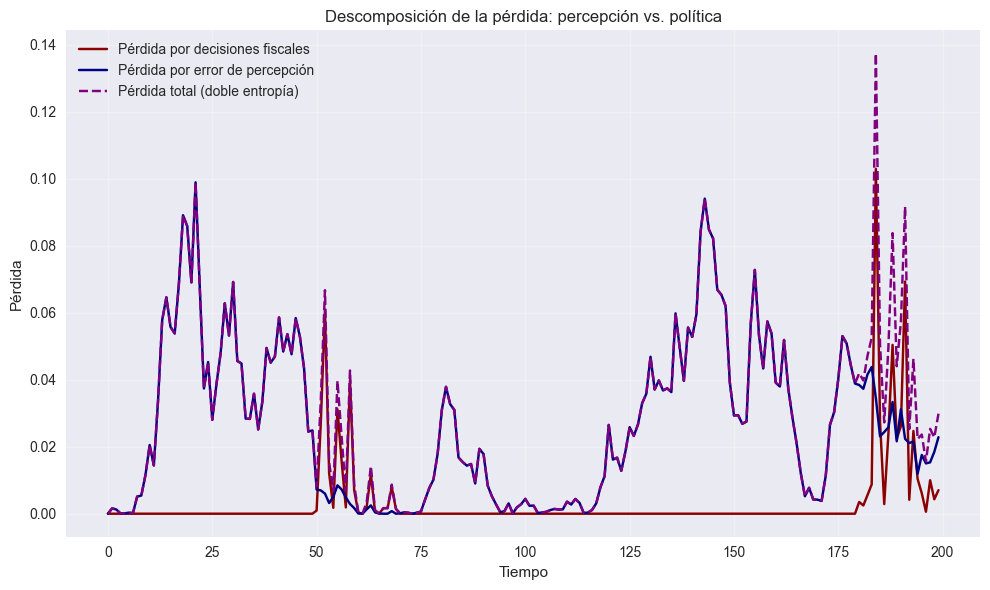

Pérdida total acumulada por doble entropía: 5.9251


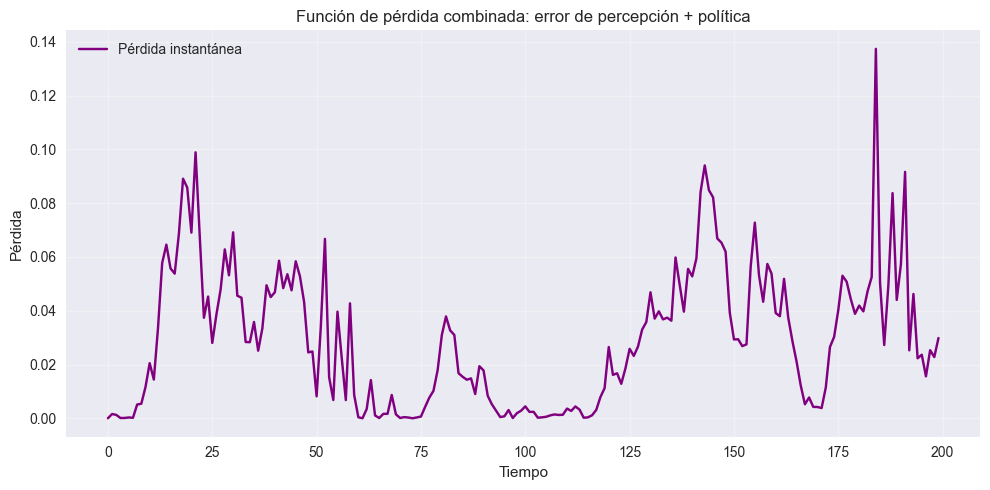


Comparando simulaciones: información perfecta vs. percepción imperfecta

Descomposición del error de política fiscal:
Error medio total (percepción imperfecta): 0.0156
Error medio con información perfecta: 0.0140
Error medio atribuible a percepción sesgada: 0.0202


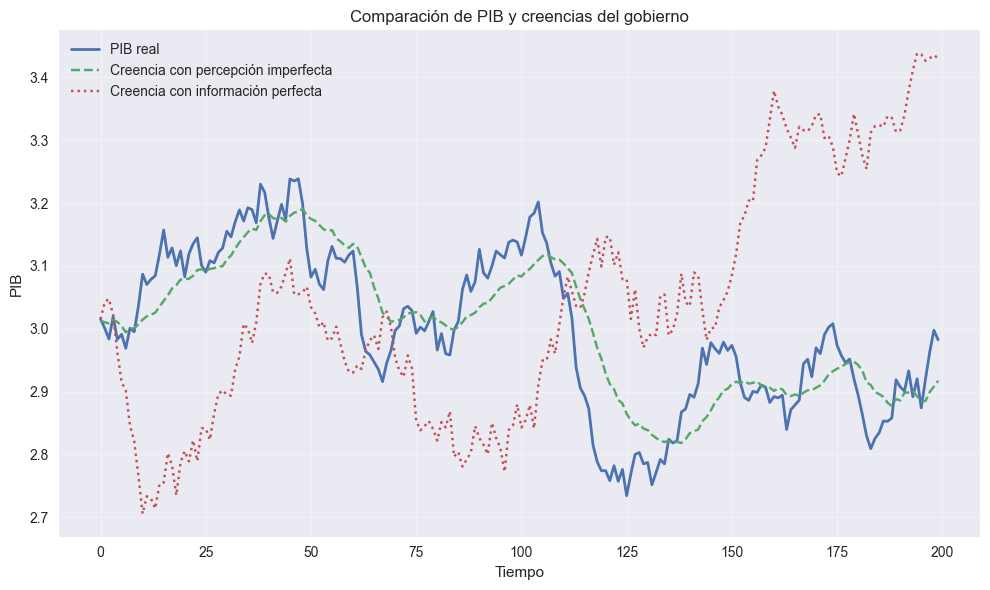

In [20]:
# Compare simulations: information perfect vs. biased perception

def compare_perception_vs_perfect_info(model, uncertainty_episodes, bias=-0.05):
    print("\nComparando simulaciones: información perfecta vs. percepción imperfecta")

    # Simulación con percepción imperfecta
    results_biased = model.simulate_model(T=200, uncertainty_episodes=uncertainty_episodes, bias=bias)

    # Simulación con percepción perfecta (belief = y_real)
    original_extraction = model.government_signal_extraction

    def perfect_info_extraction(true_state, t, bias=0.0):
        p = model.params
        ss = model.steady_state
        k_hat, a_hat = true_state[0], true_state[1]
        k_level = ss['k'] * np.exp(k_hat)
        a_level = np.exp(a_hat)
        true_y = a_level * (k_level ** p.alpha)
        model.government_belief = true_y
        return true_y, true_y

    model.government_signal_extraction = perfect_info_extraction
    results_perfect = model.simulate_model(T=200, uncertainty_episodes=uncertainty_episodes, bias=0.0)
    model.government_signal_extraction = original_extraction

    error_total = results_biased['policy_errors']
    error_perfect = results_perfect['policy_errors']
    error_percepcion = error_total - error_perfect

    print(f"\nDescomposición del error de política fiscal:")
    print(f"Error medio total (percepción imperfecta): {np.mean(np.abs(error_total)):.4f}")
    print(f"Error medio con información perfecta: {np.mean(np.abs(error_perfect)):.4f}")
    print(f"Error medio atribuible a percepción sesgada: {np.mean(np.abs(error_percepcion)):.4f}")

    # Gráfico comparativo de creencias
    plt.figure(figsize=(10, 6))
    plt.plot(results_biased['y_series'], label='PIB real', linewidth=2)
    plt.plot(results_biased['beliefs'], label='Creencia con percepción imperfecta', linestyle='--')
    plt.plot(results_perfect['beliefs'], label='Creencia con información perfecta', linestyle=':')
    plt.title('Comparación de PIB y creencias del gobierno')
    plt.xlabel('Tiempo')
    plt.ylabel('PIB')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results_biased, results_perfect, error_percepcion

# Ejecutar comparación

# Función de pérdida combinada: error de política + error de percepción
def compute_loss(results_biased, results_perfect):
    policy_diff = results_biased['policy_errors'] - results_perfect['policy_errors']
    perception_diff = results_biased['beliefs'] - results_biased['y_series']
    loss_t = policy_diff**2 + perception_diff**2
    total_loss = np.sum(loss_t)
    print(f"Pérdida total acumulada por doble entropía: {total_loss:.4f}")
    return loss_t, total_loss

# Calcular y graficar la función de pérdida
loss_t, total_loss = compute_loss(results_biased, results_perfect)

# Separación de las dos fuentes de entropía
policy_diff = results_biased['policy_errors'] - results_perfect['policy_errors']
perception_diff = results_biased['beliefs'] - results_biased['y_series']
loss_policy = policy_diff**2
loss_perception = perception_diff**2

plt.figure(figsize=(10, 6))
plt.plot(loss_policy, label='Pérdida por decisiones fiscales', color='darkred')
plt.plot(loss_perception, label='Pérdida por error de percepción', color='navy')
plt.plot(loss_t, label='Pérdida total (doble entropía)', color='purple', linestyle='--')
plt.title('Descomposición de la pérdida: percepción vs. política')
plt.xlabel('Tiempo')
plt.ylabel('Pérdida')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
loss_t, total_loss = compute_loss(results_biased, results_perfect)

plt.figure(figsize=(10, 5))
plt.plot(loss_t, label='Pérdida instantánea', color='purple')
plt.title('Función de pérdida combinada: error de percepción + política')
plt.xlabel('Tiempo')
plt.ylabel('Pérdida')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

results_biased, results_perfect, error_percepcion = compare_perception_vs_perfect_info(model, uncertainty_episodes, bias=-0)

